In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install ucimlrepo

# --- Core Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# --- Preprocessing and Metrics ---
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# --- Machine Learning Models ---
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC

# --- Data Loading ---
from ucimlrepo import fetch_ucirepo

# --- Settings ---
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")

# Fetch dataset
try:
    maternal_health_risk = fetch_ucirepo(id=863)
    X = maternal_health_risk.data.features
    y = maternal_health_risk.data.targets
    df = pd.concat([X, y], axis=1)
    print("--- Dataset loaded successfully ---")
    print(f"Dataset shape: {df.shape}")
except Exception as e:
    print(f"Failed to load dataset. Error: {e}")
    df = pd.DataFrame() # Create empty dataframe to avoid further errors


  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
--- Dataset loaded successfully ---
Dataset shape: (1014, 7)


In [ ]:
print("Data Info:")
df.info()
print("\n" + "="*40 + "\n")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB




In [ ]:
# --- 3. Check for Missing Values ---
print("--- Missing Values Check ---")
missing_values = df.isnull().sum()
print("Number of missing values per column:")
print(missing_values)
print("\n" + "="*40 + "\n")

--- Missing Values Check ---
Number of missing values per column:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64




In [ ]:
# --- 4. Check for Duplicated Values ---
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows found: {num_duplicates}")
print("The dataset has many duplicated rows.\nbut I decided to keep them as same as the paper.\nIn the next try I'm going to remove these and compare the result")
print("\n" + "="*40 + "\n")


Number of duplicate rows found: 562
The dataset has many duplicated rows.
but I decided to keep them as same as the paper.
In the next try I'm going to remove these and compare the result




In [ ]:
# --- 5. Handle Outliers using IQR ---
print("--- Handling Outliers using IQR ---")
print("For this specific problem, the presence of statistical outliers is\na key feature of the data, not a flaw.Proceeding without removing them\nis the correct approach to build a meaningful risk prediction model.")
print("\n" + "="*40 + "\n")

--- Handling Outliers using IQR ---
For this specific problem, the presence of statistical outliers is
a key feature of the data, not a flaw.Proceeding without removing them
is the correct approach to build a meaningful risk prediction model.




--- Visualizing Data Distribution ---


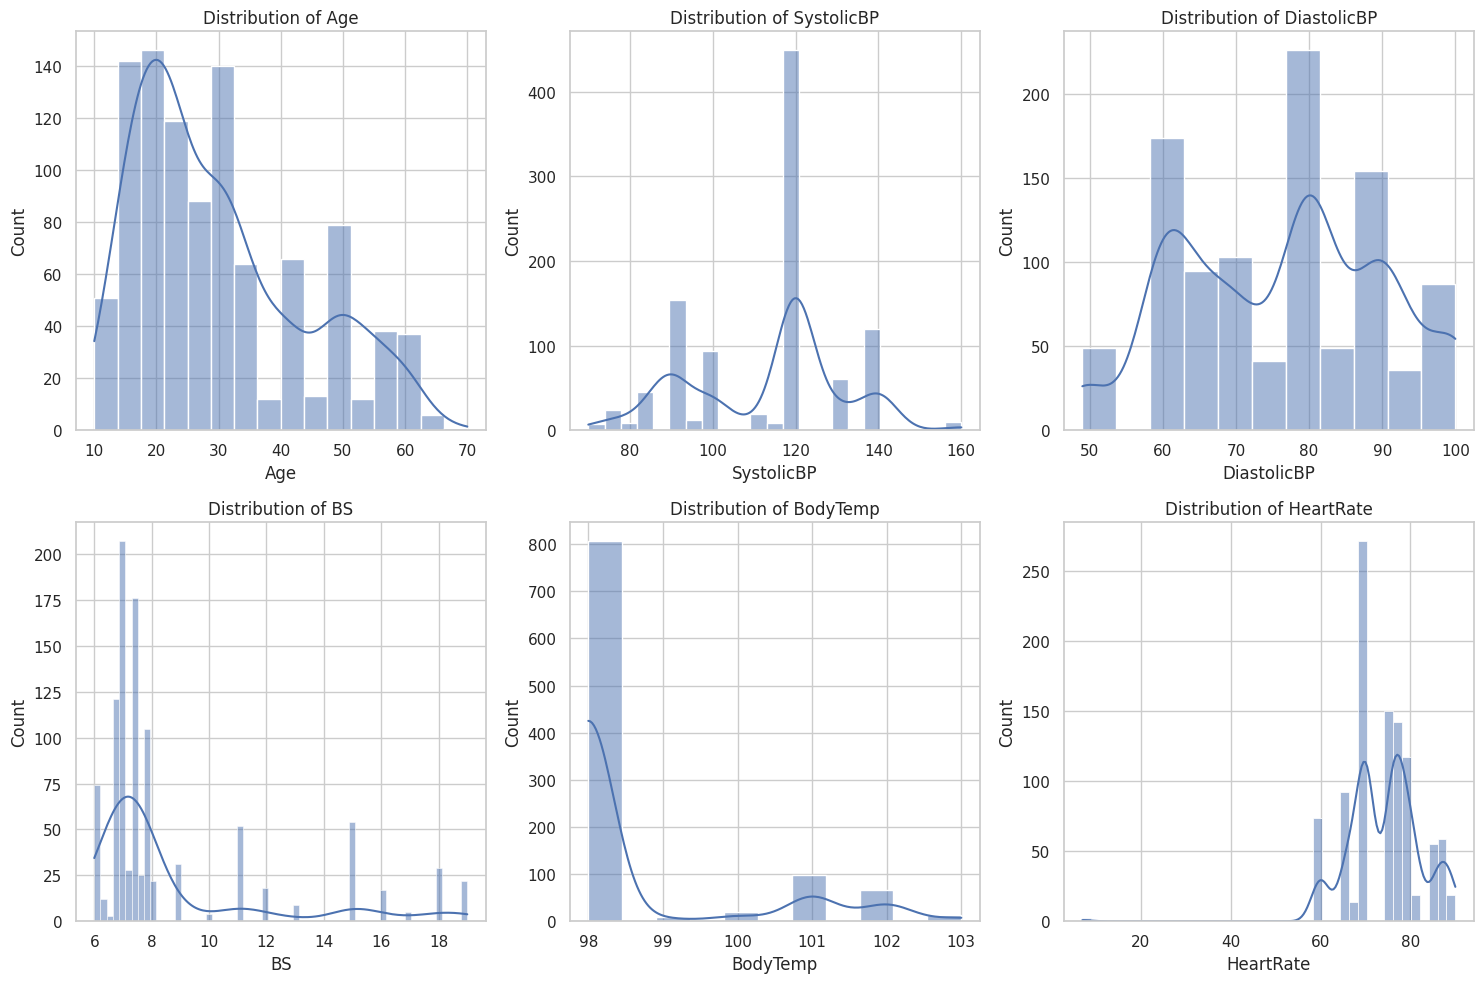

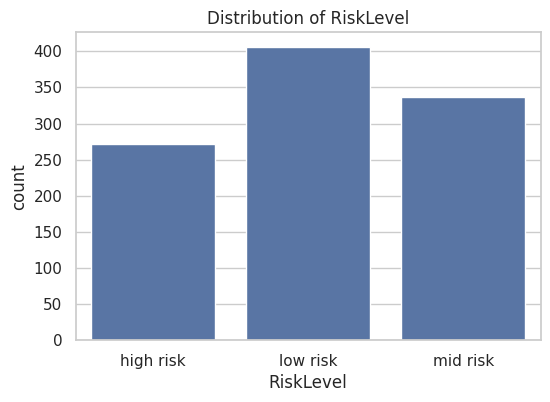

In [ ]:
# --- 6. Visualize Data Distribution ---
print("--- Visualizing Data Distribution ---")

# Plot distribution of numerical features
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Plot distribution of the target variable (categorical)
plt.figure(figsize=(6, 4))
sns.countplot(x='RiskLevel', data=df)
plt.title('Distribution of RiskLevel')
plt.show()

print("\n" + "="*40 + "\n")

In [ ]:
risk_mapping = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
df['RiskLevel_encoded_manual'] = df['RiskLevel'].map(risk_mapping)

print(df[['RiskLevel', 'RiskLevel_encoded_manual']].head())

   RiskLevel  RiskLevel_encoded_manual
0  high risk                         2
1  high risk                         2
2  high risk                         2
3  high risk                         2
4   low risk                         0


In [ ]:
# --- 7. Feature Scaling (Standardization) ---
print("--- Feature Scaling (Standardization) ---")

# Select numerical columns for scaling, EXCLUDING the encoded target variable
numerical_cols_to_scale = df.select_dtypes(include=['int64', 'float64']).columns.drop('RiskLevel_encoded_manual')

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the numerical columns
df[numerical_cols_to_scale] = scaler.fit_transform(df[numerical_cols_to_scale])

print("DataFrame after standardization:")
display(df.head())
print("\n" + "="*40 + "\n")

--- Feature Scaling (Standardization) ---
DataFrame after standardization:


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,RiskLevel_encoded_manual
0,-0.361738,0.913396,0.255023,1.905890,-0.485215,1.446956,high risk,2
1,0.380777,1.457027,0.975539,1.298340,-0.485215,-0.532088,high risk,2
2,-0.064732,-1.261127,-0.465493,-0.220537,0.973884,0.704815,high risk,2
3,0.009519,1.457027,0.615281,-0.524312,-0.485215,-0.532088,high risk,2
4,0.380777,0.369765,-1.186009,-0.797710,-0.485215,0.210054,low risk,0


--- Analyzing Data Correlation using PCA ---


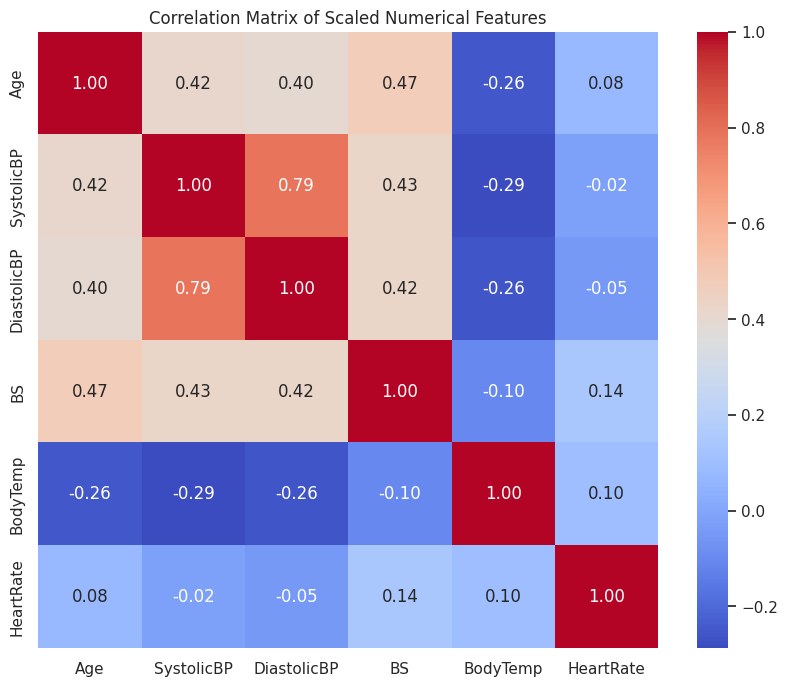


Explained variance ratio by each principal component:
[0.4346489  0.1907302  0.13950832 0.11772242 0.08209058 0.03529959]

Cumulative explained variance:
[0.4346489  0.6253791  0.76488741 0.88260984 0.96470041 1.        ]


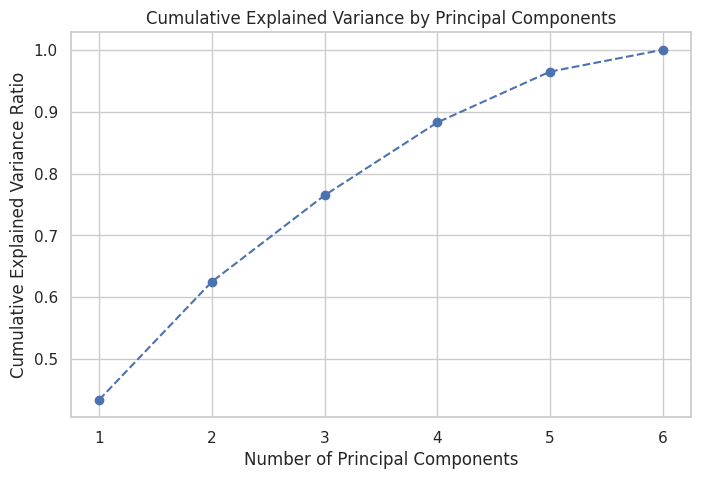

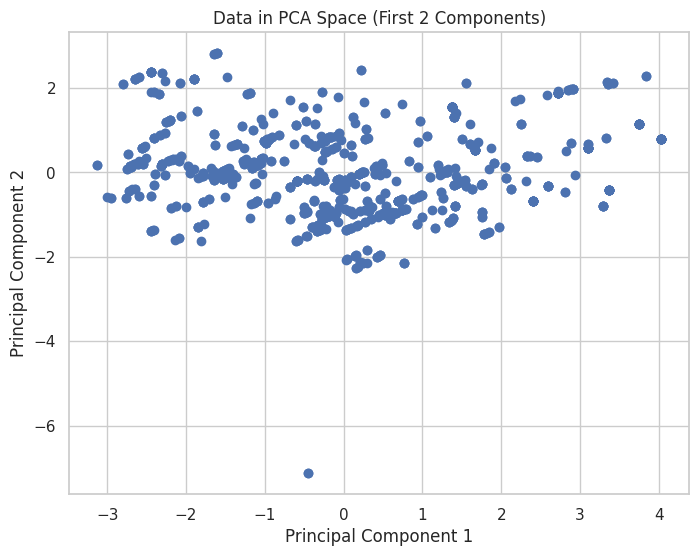

In [ ]:
# --- Analyze Data Correlation using PCA ---
print("--- Analyzing Data Correlation using PCA ---")

# Select only the scaled numerical columns for correlation and PCA
scaled_numerical_df = df[numerical_cols]

# Calculate and visualize the correlation matrix
correlation_matrix = scaled_numerical_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Scaled Numerical Features')
plt.show()

# Perform PCA
pca = PCA()
pca.fit(scaled_numerical_df)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("\nExplained variance ratio by each principal component:")
print(explained_variance_ratio)

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print("\nCumulative explained variance:")
print(cumulative_explained_variance)

# Visualize the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# You can also visualize the data in the PCA space if needed
# For example, visualizing the first two principal components:
pca_2d = PCA(n_components=2)
principal_components = pca_2d.fit_transform(scaled_numerical_df)
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.title('Data in PCA Space (First 2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print("\n" + "="*40 + "\n")

In [ ]:
GENERATE_PROFILE_REPORT = False # Set to True to generate the report
if GENERATE_PROFILE_REPORT:
    print("\n\n--- Generating Pandas Profiling Report (on the preprocessed DataFrame 'df') ---")
    if 'df' in locals() and not df.empty:
        profile = ProfileReport(df, title="Pandas Profiling Report (After Preprocessing)", explorative=True)
        profile.to_file("profile_report_after_preprocessing.html")
        print("Profile report saved to 'profile_report_after_preprocessing.html'")
    else:
        print("DataFrame 'df' not available for profiling.")
else:
    print("\nSkipping Pandas Profiling report generation (GENERATE_PROFILE_REPORT is False).")


Skipping Pandas Profiling report generation (GENERATE_PROFILE_REPORT is False).


In [ ]:
# --- Helper Function to Plot ROC Curves ---
def plot_multiclass_roc(clf, X_test, y_test, n_classes, class_names, figsize=(10, 6)):
    """
    Plots the ROC curve for each class in a multi-class classification problem.
    """
    try:
        y_score = clf.predict_proba(X_test)
    except AttributeError:
        print(f"Model {type(clf).__name__} does not support predict_proba. Skipping ROC curve.")
        return

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver Operating Characteristic (ROC) - {type(clf).__name__}')
    colors = plt.cm.get_cmap('viridis', n_classes)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                label=f'ROC curve for {class_names[i]} (area = {roc_auc[i]:.2f})')
    ax.legend(loc="lower right")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()



In [ ]:
# Features are the scaled numerical columns, EXCLUDING the encoded target variable
features = df.select_dtypes(include=np.number).drop('RiskLevel_encoded_manual', axis=1).columns
X = df[features]

# Target is the manually encoded 'RiskLevel', which should NOT be scaled
y = df['RiskLevel_encoded_manual']

# Get class names from the original 'RiskLevel' column for plotting
le = LabelEncoder().fit(df['RiskLevel'])
class_names = le.classes_
n_classes = len(class_names)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("--- Data for Modeling ---")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of classes: {n_classes}")
print(f"Class names: {list(class_names)}")
print("\n" + "="*80 + "\n")

--- Data for Modeling ---
Training set shape: (811, 6)
Test set shape: (203, 6)
Number of classes: 3
Class names: ['high risk', 'low risk', 'mid risk']




In [ ]:
results_list = []

param_grids = {
    "RandomForest": {
        "n_estimators": [50, 100, 150, 200, 300],
        "max_depth": [5, 10, 15, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "class_weight": ["balanced"]
    },
    "SVC": {
        "C": [0.01, 0.1, 1, 10, 100, 1000],
        "kernel": ["rbf"],
        "gamma": [0.01, 0.1, 0.5, 1, 2, 3, 4, 10],
        "probability": [True]
    },
    "Bagging": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.7, 1.0],
        "max_features": [0.5, 0.7, 1.0],
    },
    "DecisionTree": {
        "max_depth": [5, 10, 15, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "criterion": ["gini", "entropy"],
        "class_weight": ["balanced"]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 9, 11],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"]
    }
}


models = {
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "SVC": SVC(kernel='rbf', gamma=2, C=100, probability=True, random_state=42),
}



--- Starting Block 1: Train-Test Split Evaluation (80/20) ---

--- Evaluating Model: LDA ---
Accuracy: 0.6256
Macro Precision: 0.6383
Macro Recall: 0.6329
Macro F1-Score: 0.6355
ROC AUC (OvR): 0.8112

Classification Report:
              precision    recall  f1-score   support

   high risk       0.65      0.65      0.65        81
    low risk       0.45      0.46      0.46        67
    mid risk       0.81      0.78      0.80        55

    accuracy                           0.63       203
   macro avg       0.64      0.63      0.64       203
weighted avg       0.63      0.63      0.63       203



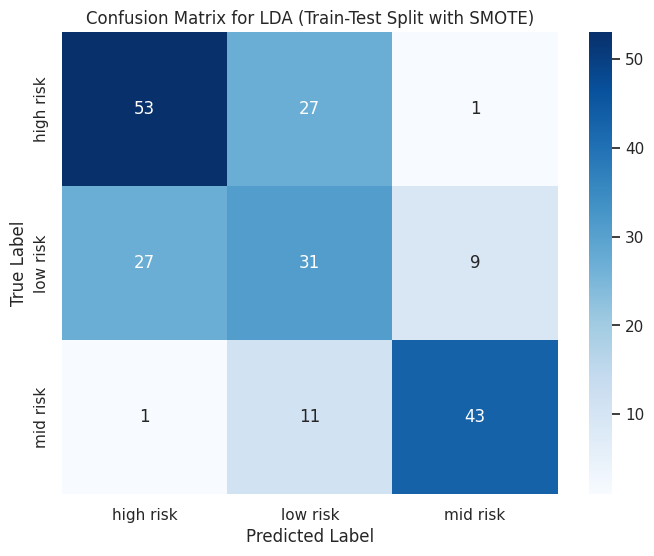

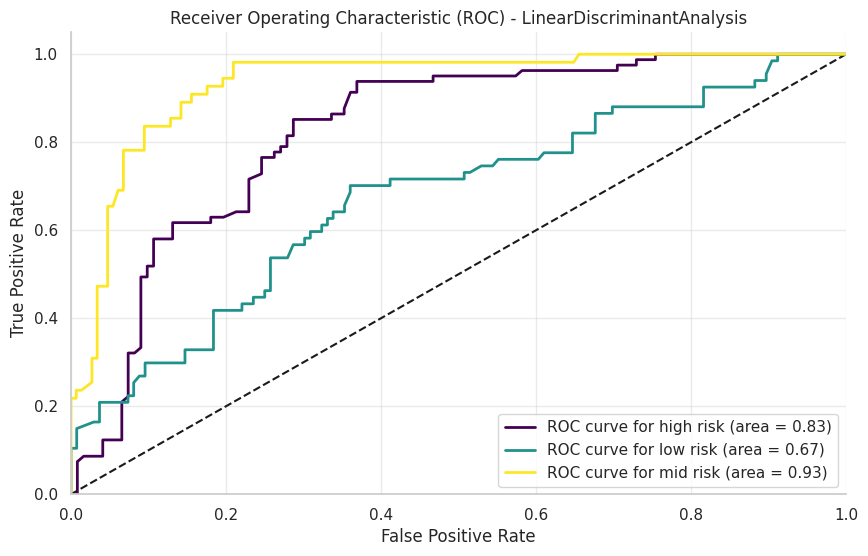


--- Evaluating Model: QDA ---
Accuracy: 0.6453
Macro Precision: 0.6452
Macro Recall: 0.6395
Macro F1-Score: 0.6325
ROC AUC (OvR): 0.7996

Classification Report:
              precision    recall  f1-score   support

   high risk       0.63      0.81      0.71        81
    low risk       0.53      0.36      0.43        67
    mid risk       0.77      0.75      0.76        55

    accuracy                           0.65       203
   macro avg       0.65      0.64      0.63       203
weighted avg       0.64      0.65      0.63       203



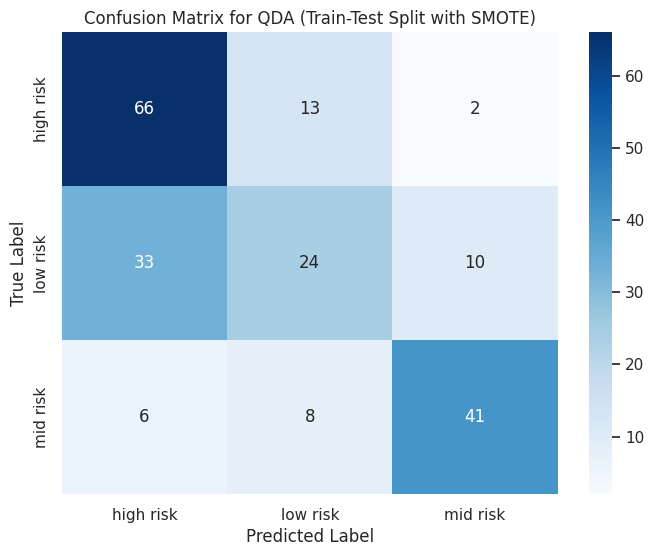

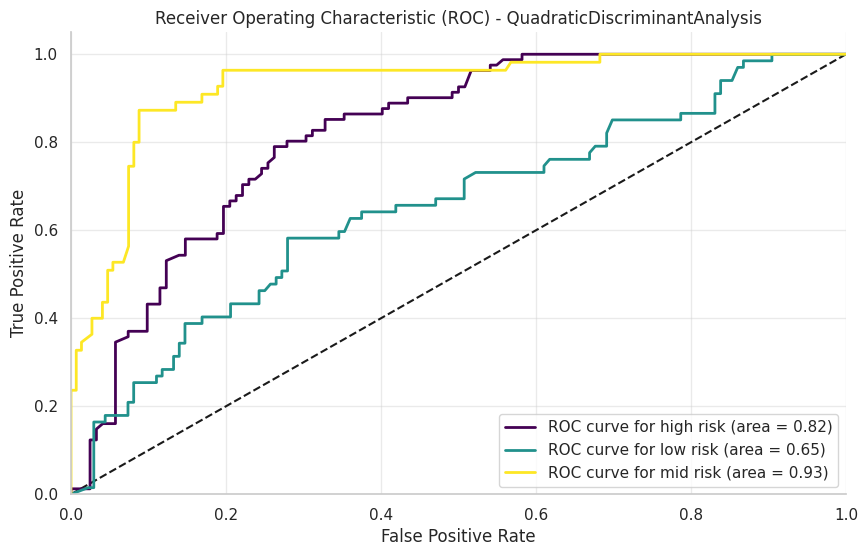


--- Evaluating Model: KNN ---
Accuracy: 0.7192
Macro Precision: 0.7251
Macro Recall: 0.7292
Macro F1-Score: 0.7270
ROC AUC (OvR): 0.8726

Classification Report:
              precision    recall  f1-score   support

   high risk       0.71      0.69      0.70        81
    low risk       0.64      0.64      0.64        67
    mid risk       0.82      0.85      0.84        55

    accuracy                           0.72       203
   macro avg       0.73      0.73      0.73       203
weighted avg       0.72      0.72      0.72       203



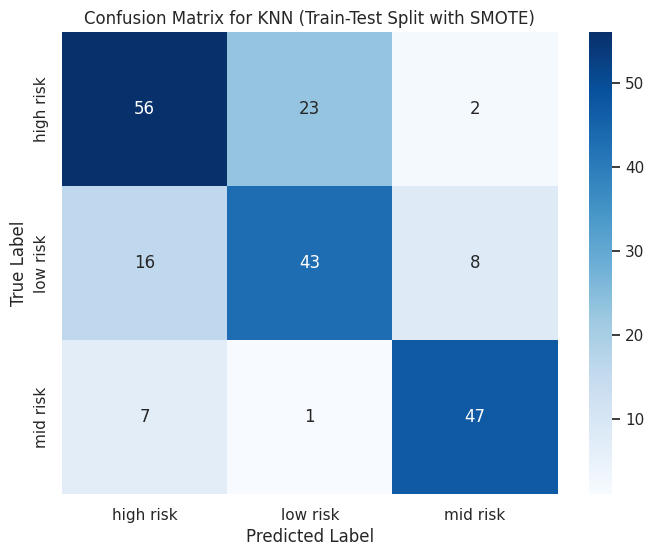

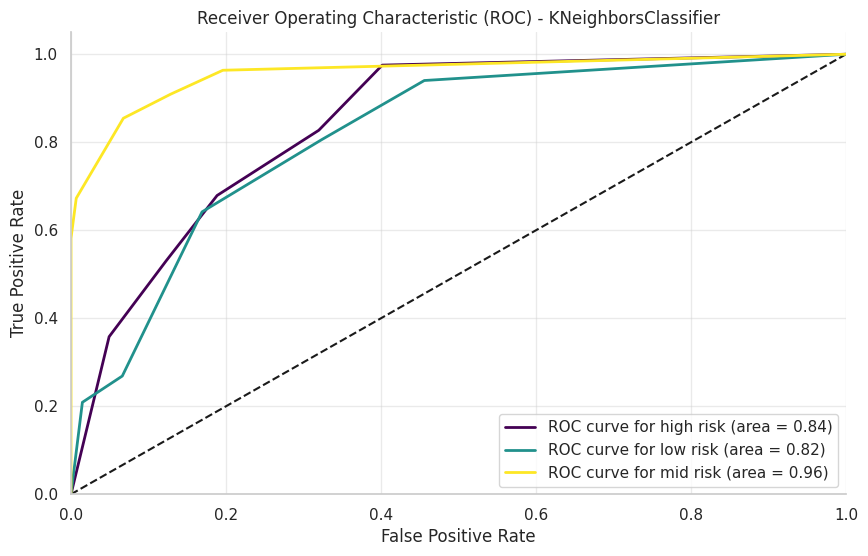


--- Evaluating Model: KNN + GS ---
--> Running GridSearchCV for KNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
--> Best Parameters: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Accuracy: 0.8128
Macro Precision: 0.8187
Macro Recall: 0.8160
Macro F1-Score: 0.8169
ROC AUC (OvR): 0.9400

Classification Report:
              precision    recall  f1-score   support

   high risk       0.83      0.80      0.82        81
    low risk       0.74      0.79      0.76        67
    mid risk       0.89      0.85      0.87        55

    accuracy                           0.81       203
   macro avg       0.82      0.82      0.82       203
weighted avg       0.82      0.81      0.81       203



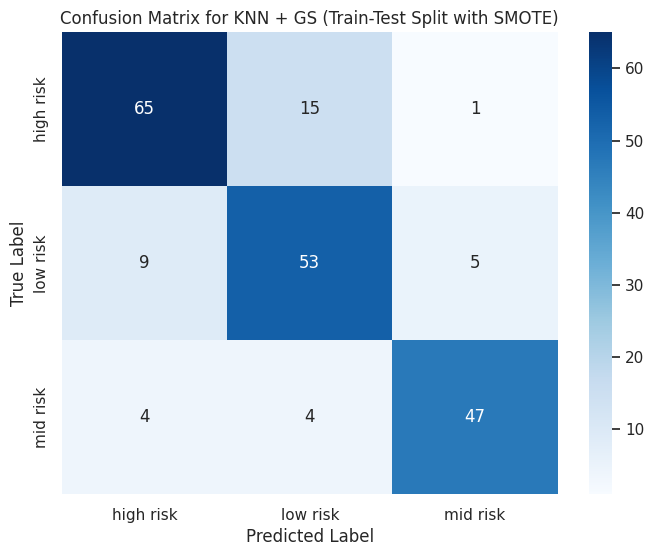

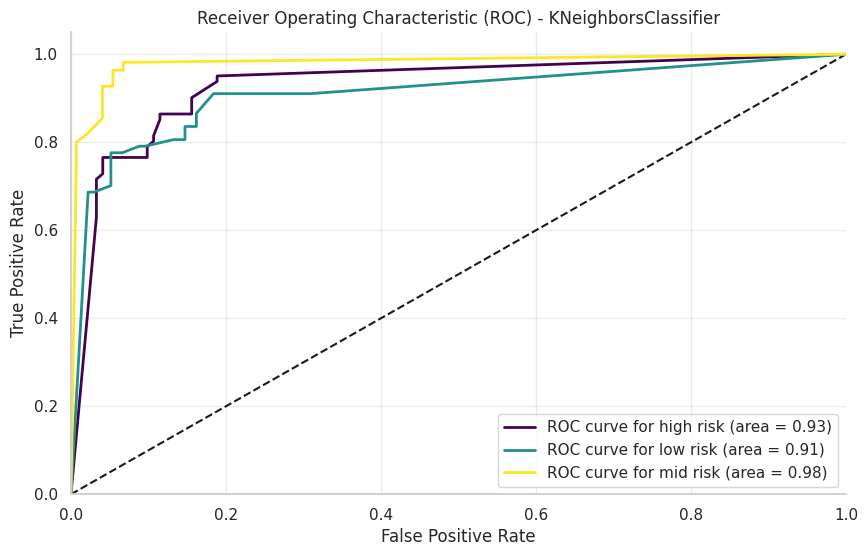


--- Evaluating Model: DecisionTree ---
Accuracy: 0.8227
Macro Precision: 0.8256
Macro Recall: 0.8281
Macro F1-Score: 0.8263
ROC AUC (OvR): 0.9252

Classification Report:
              precision    recall  f1-score   support

   high risk       0.86      0.80      0.83        81
    low risk       0.75      0.79      0.77        67
    mid risk       0.88      0.89      0.88        55

    accuracy                           0.82       203
   macro avg       0.83      0.83      0.83       203
weighted avg       0.82      0.82      0.82       203



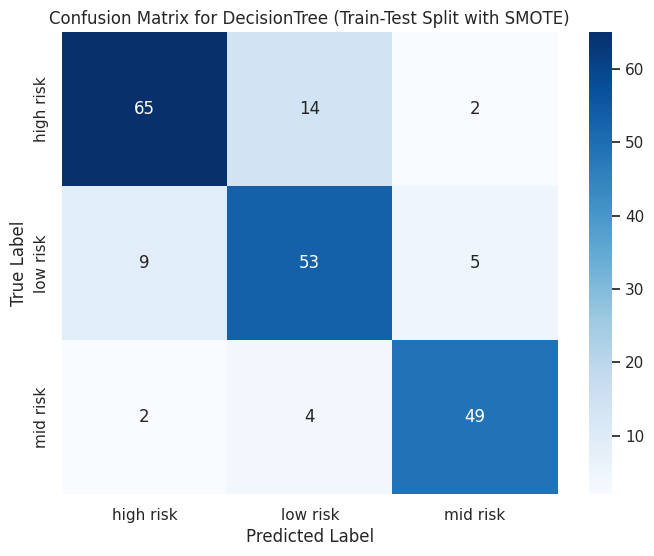

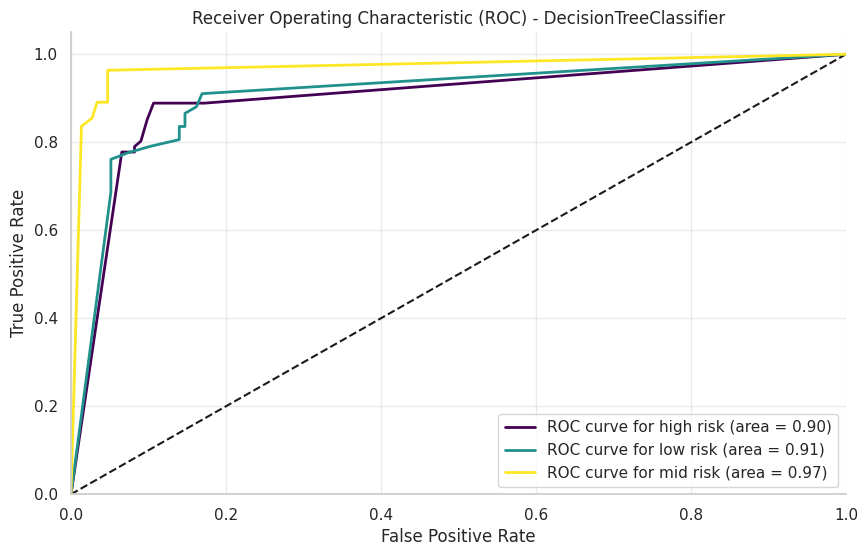


--- Evaluating Model: DecisionTree + GS ---
--> Running GridSearchCV for DecisionTree...
Fitting 5 folds for each of 90 candidates, totalling 450 fits
--> Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.8276
Macro Precision: 0.8315
Macro Recall: 0.8323
Macro F1-Score: 0.8315
ROC AUC (OvR): 0.9286

Classification Report:
              precision    recall  f1-score   support

   high risk       0.86      0.81      0.84        81
    low risk       0.75      0.79      0.77        67
    mid risk       0.89      0.89      0.89        55

    accuracy                           0.83       203
   macro avg       0.83      0.83      0.83       203
weighted avg       0.83      0.83      0.83       203



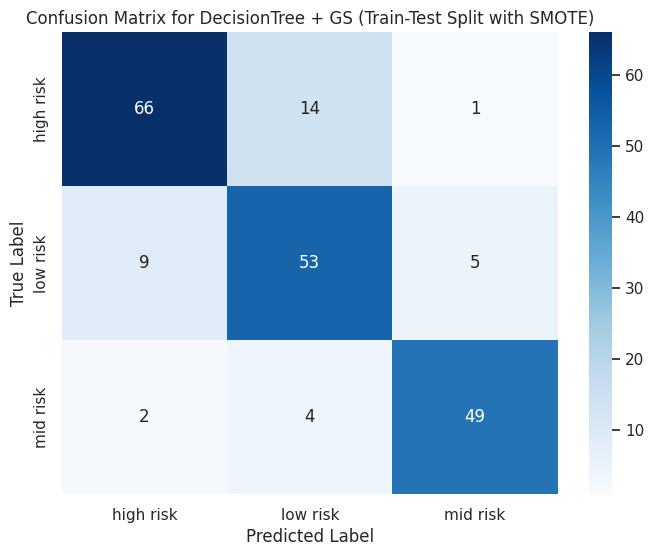

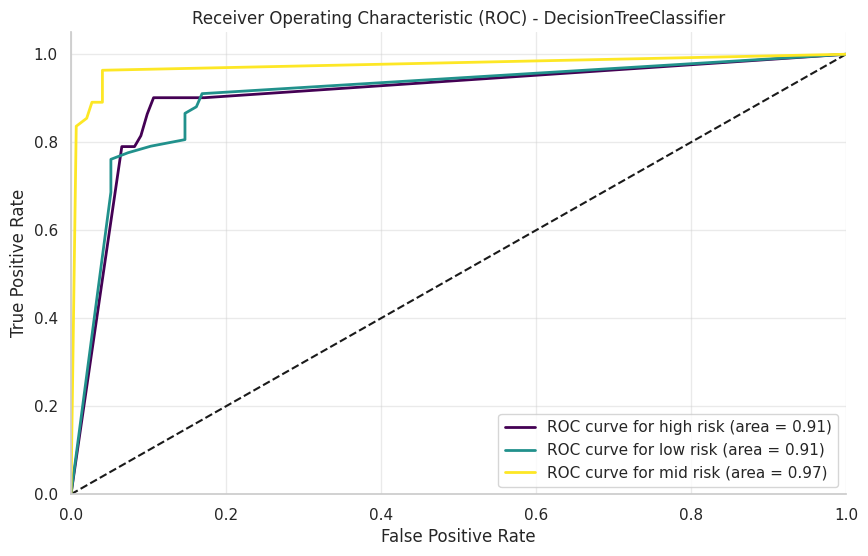


--- Evaluating Model: RandomForest ---
Accuracy: 0.8473
Macro Precision: 0.8480
Macro Recall: 0.8574
Macro F1-Score: 0.8517
ROC AUC (OvR): 0.9502

Classification Report:
              precision    recall  f1-score   support

   high risk       0.87      0.80      0.83        81
    low risk       0.79      0.81      0.80        67
    mid risk       0.88      0.96      0.92        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.85       203
weighted avg       0.85      0.85      0.85       203



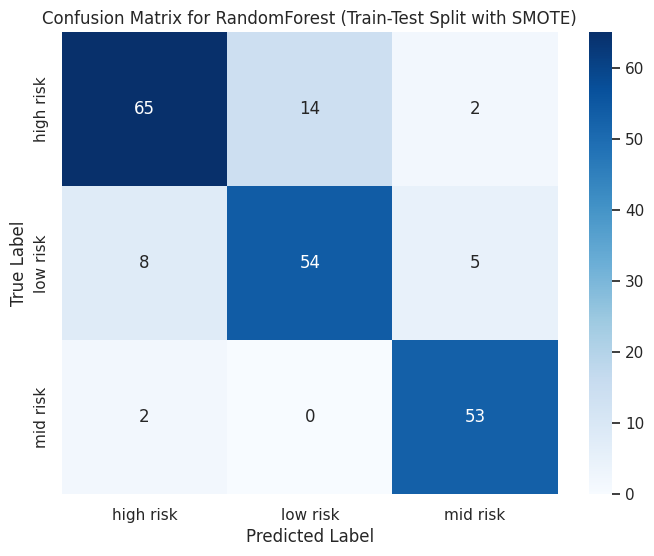

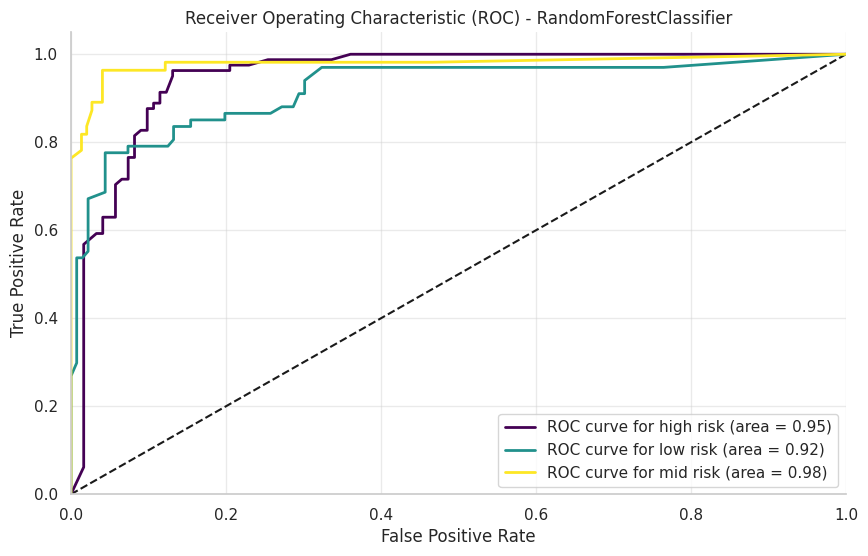


--- Evaluating Model: RandomForest + GS ---
--> Running GridSearchCV for RandomForest...
Fitting 5 folds for each of 225 candidates, totalling 1125 fits
--> Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy: 0.8473
Macro Precision: 0.8478
Macro Recall: 0.8565
Macro F1-Score: 0.8514
ROC AUC (OvR): 0.9548

Classification Report:
              precision    recall  f1-score   support

   high risk       0.86      0.81      0.84        81
    low risk       0.80      0.79      0.80        67
    mid risk       0.88      0.96      0.92        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.85       203
weighted avg       0.85      0.85      0.85       203



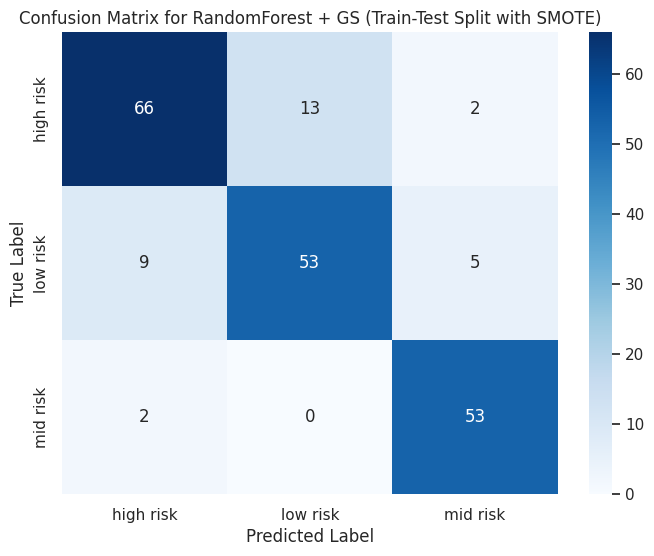

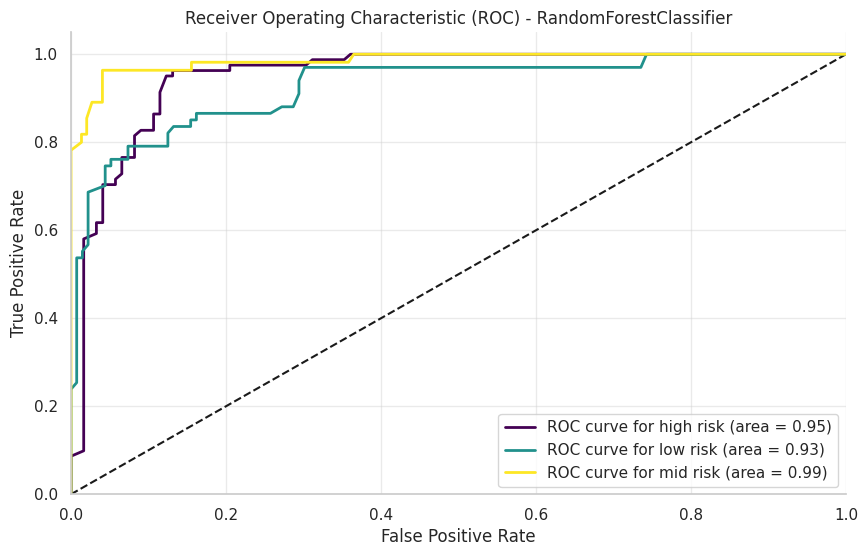


--- Evaluating Model: Bagging ---
Accuracy: 0.8177
Macro Precision: 0.8214
Macro Recall: 0.8221
Macro F1-Score: 0.8211
ROC AUC (OvR): 0.9436

Classification Report:
              precision    recall  f1-score   support

   high risk       0.86      0.80      0.83        81
    low risk       0.74      0.79      0.76        67
    mid risk       0.87      0.87      0.87        55

    accuracy                           0.82       203
   macro avg       0.82      0.82      0.82       203
weighted avg       0.82      0.82      0.82       203



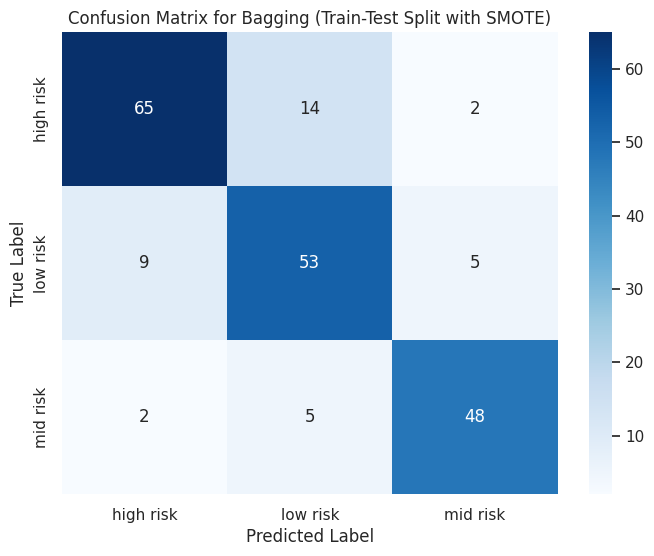

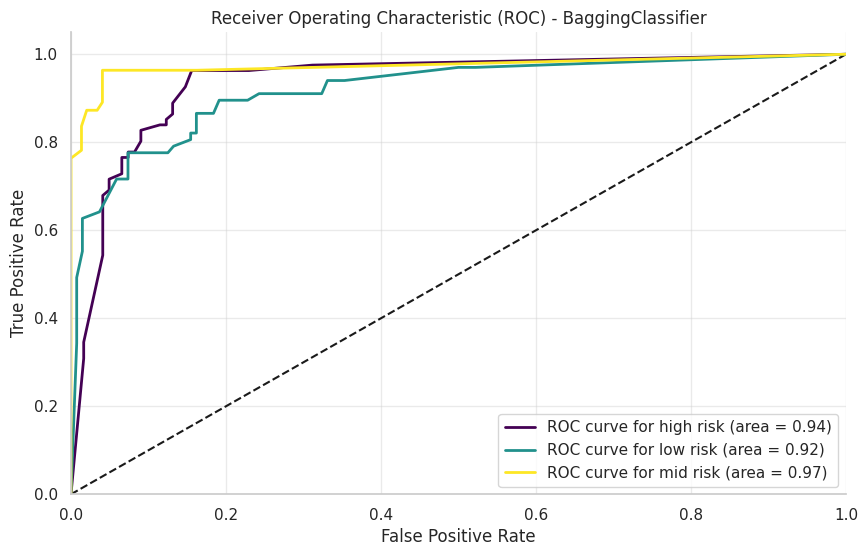


--- Evaluating Model: Bagging + GS ---
--> Running GridSearchCV for Bagging...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
--> Best Parameters: {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 50}
Accuracy: 0.8473
Macro Precision: 0.8488
Macro Recall: 0.8556
Macro F1-Score: 0.8517
ROC AUC (OvR): 0.9429

Classification Report:
              precision    recall  f1-score   support

   high risk       0.85      0.83      0.84        81
    low risk       0.80      0.78      0.79        67
    mid risk       0.90      0.96      0.93        55

    accuracy                           0.85       203
   macro avg       0.85      0.86      0.85       203
weighted avg       0.85      0.85      0.85       203



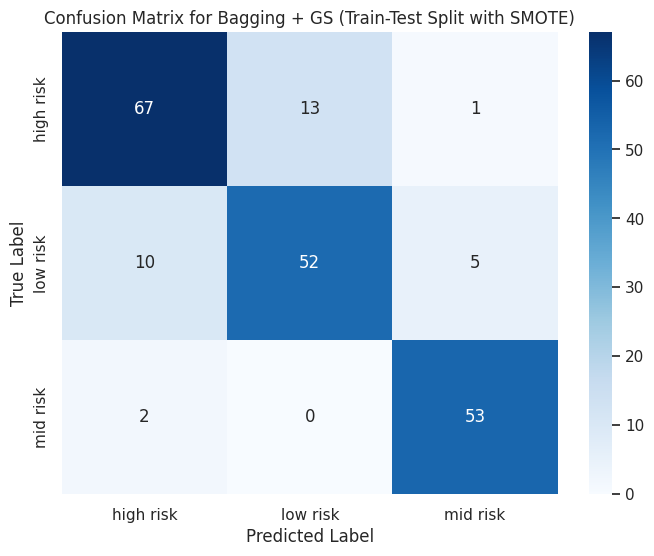

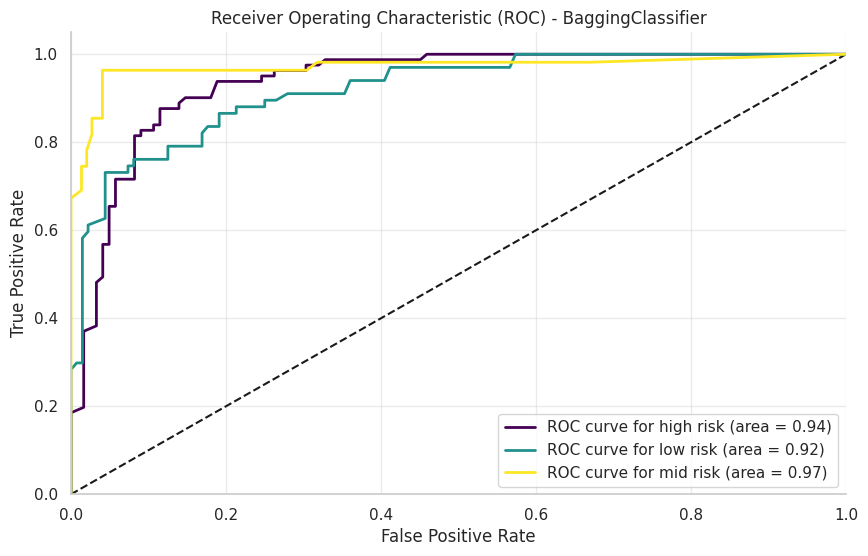


--- Evaluating Model: SVC ---
Accuracy: 0.8079
Macro Precision: 0.8081
Macro Recall: 0.8199
Macro F1-Score: 0.8124
ROC AUC (OvR): 0.9092

Classification Report:
              precision    recall  f1-score   support

   high risk       0.82      0.75      0.79        81
    low risk       0.76      0.76      0.76        67
    mid risk       0.84      0.95      0.89        55

    accuracy                           0.81       203
   macro avg       0.81      0.82      0.81       203
weighted avg       0.81      0.81      0.81       203



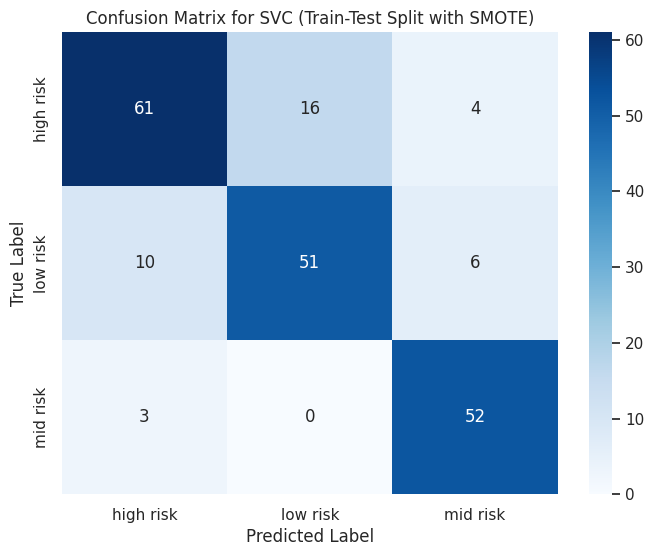

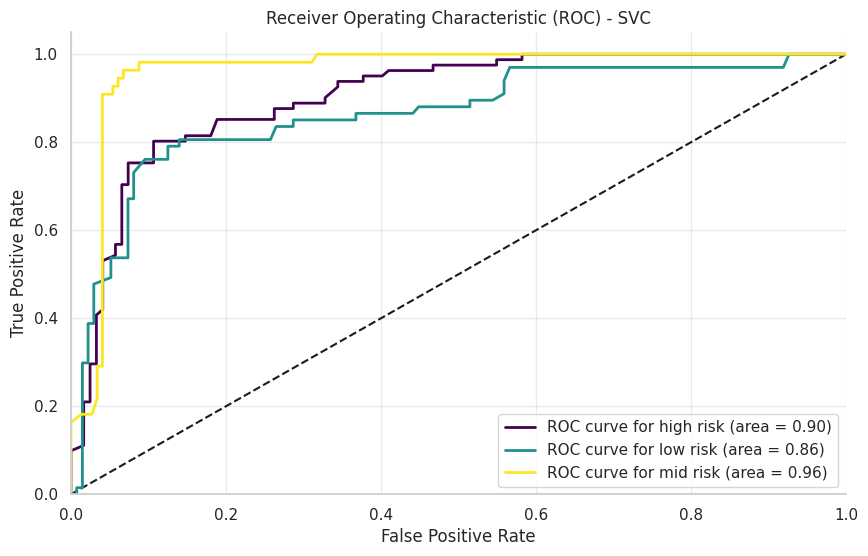


--- Evaluating Model: SVC + GS ---
--> Running GridSearchCV for SVC...
Fitting 5 folds for each of 48 candidates, totalling 240 fits
--> Best Parameters: {'C': 1000, 'gamma': 3, 'kernel': 'rbf', 'probability': True}
Accuracy: 0.8227
Macro Precision: 0.8233
Macro Recall: 0.8359
Macro F1-Score: 0.8267
ROC AUC (OvR): 0.9203

Classification Report:
              precision    recall  f1-score   support

   high risk       0.87      0.75      0.81        81
    low risk       0.76      0.79      0.77        67
    mid risk       0.84      0.96      0.90        55

    accuracy                           0.82       203
   macro avg       0.82      0.84      0.83       203
weighted avg       0.83      0.82      0.82       203



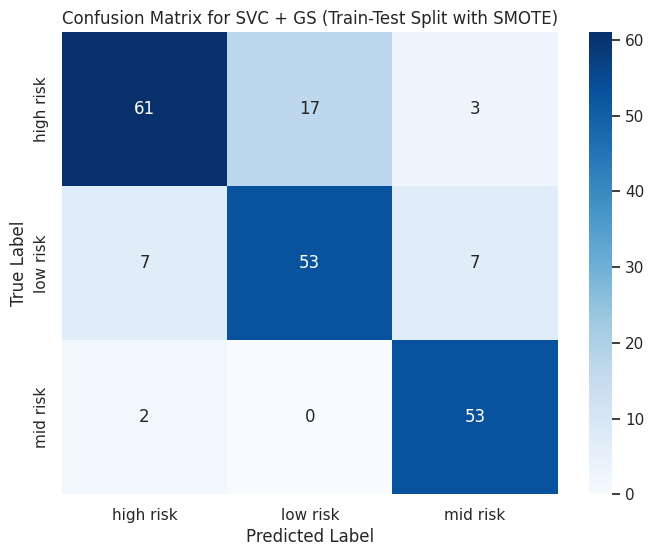

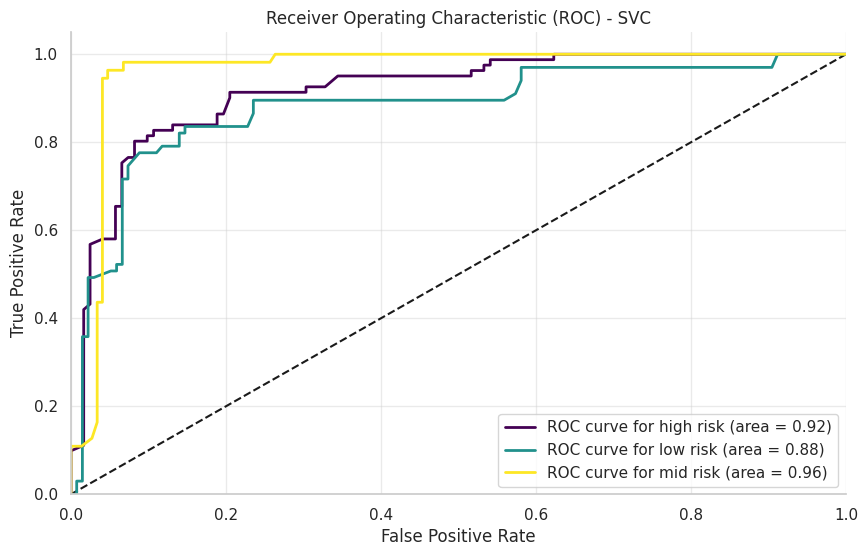


--- Finished Block 1: Train-Test Split Evaluation (80/20) ---



In [ ]:
print("--- Starting Block 1: Train-Test Split Evaluation (80/20) ---")

# Initialize SMOTE
smote = SMOTE(random_state=42)

for name, model in models.items():
    for use_grid in [False, True]:

        # Skip GridSearch if model has no param_grid
        if use_grid and name not in param_grids:
            continue

        tag = " + GS" if use_grid else ""
        print(f"\n--- Evaluating Model: {name}{tag} ---")

        # Apply SMOTE to the training data
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        if use_grid:
            print(f"--> Running GridSearchCV for {name}...")
            gs = GridSearchCV(model, param_grids[name], cv=5, scoring='f1_macro', n_jobs=-1, verbose=1)
            gs.fit(X_train_smote, y_train_smote)
            best_model = gs.best_estimator_
            print(f"--> Best Parameters: {gs.best_params_}")
        else:
            model.fit(X_train_smote, y_train_smote)
            best_model = model

        # Make predictions
        y_pred = best_model.predict(X_test)
        y_proba = best_model.predict_proba(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
        roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Macro Precision: {precision:.4f}")
        print(f"Macro Recall: {recall:.4f}")
        print(f"Macro F1-Score: {f1:.4f}")
        print(f"ROC AUC (OvR): {roc_auc:.4f}")

        # Store results
        results_list.append({
            "Model": f"{name}{tag}",
            "Evaluation Method": "Train-Test Split (with SMOTE)",
            "Accuracy": accuracy,
            "Precision (Macro)": precision,
            "Recall (Macro)": recall,
            "F1-Score (Macro)": f1,
            "ROC AUC (OvR)": roc_auc
        })

        # Classification Report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix for {name}{tag} (Train-Test Split with SMOTE)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # ROC Curve
        plot_multiclass_roc(best_model, X_test, y_test, n_classes=n_classes, class_names=class_names)

print("\n" + "="*80)
print("--- Finished Block 1: Train-Test Split Evaluation (80/20) ---")
print("="*80 + "\n")


--- Starting Block 2: 10-Fold CV with SMOTE on train fold only ---

--- Evaluating Model: LDA ---
Average Accuracy: 0.5995 (± 0.0450)
Average Macro Precision: 0.6186 (± 0.0401)
Average Macro Recall: 0.5982 (± 0.0457)
Average Macro F1-Score: 0.6036 (± 0.0432)
Average ROC AUC (OvR): 0.8035 (± 0.0233)


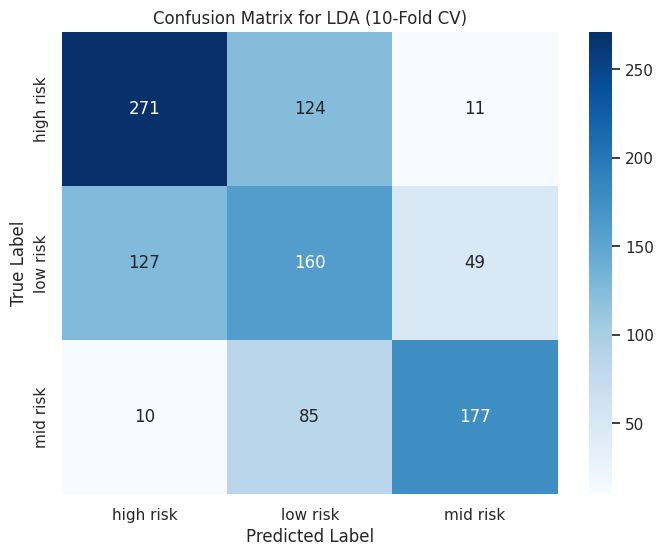

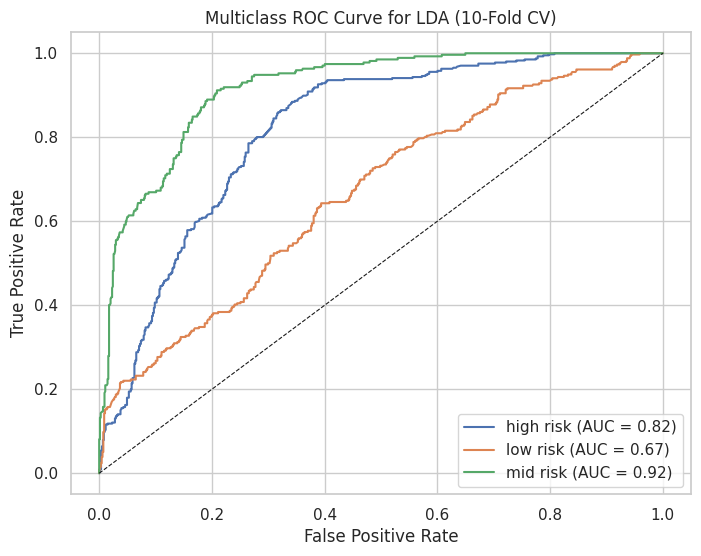


--- Evaluating Model: QDA ---
Average Accuracy: 0.6380 (± 0.0347)
Average Macro Precision: 0.6485 (± 0.0466)
Average Macro Recall: 0.6273 (± 0.0397)
Average Macro F1-Score: 0.6168 (± 0.0430)
Average ROC AUC (OvR): 0.8096 (± 0.0330)


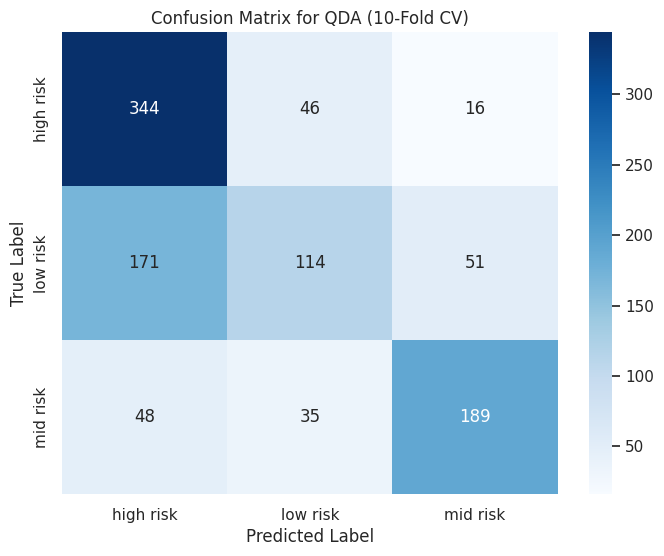

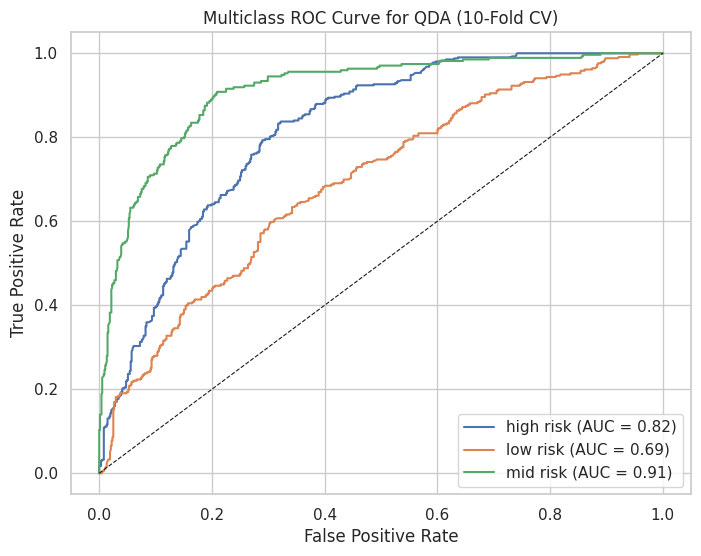


--- Evaluating Model: KNN ---
Average Accuracy: 0.7070 (± 0.0553)
Average Macro Precision: 0.7247 (± 0.0465)
Average Macro Recall: 0.7126 (± 0.0529)
Average Macro F1-Score: 0.7151 (± 0.0500)
Average ROC AUC (OvR): 0.8873 (± 0.0250)


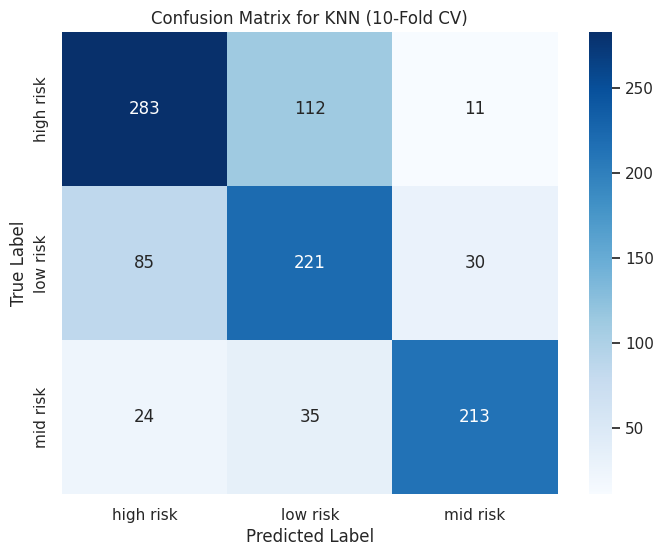

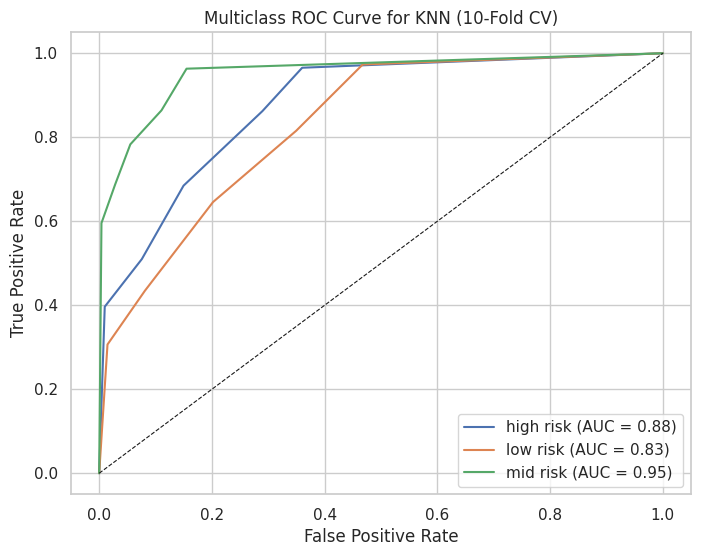


--- Evaluating Model: KNN + GS ---
Average Accuracy: 0.8382 (± 0.0323)
Average Macro Precision: 0.8484 (± 0.0254)
Average Macro Recall: 0.8453 (± 0.0317)
Average Macro F1-Score: 0.8434 (± 0.0305)
Average ROC AUC (OvR): 0.9496 (± 0.0174)


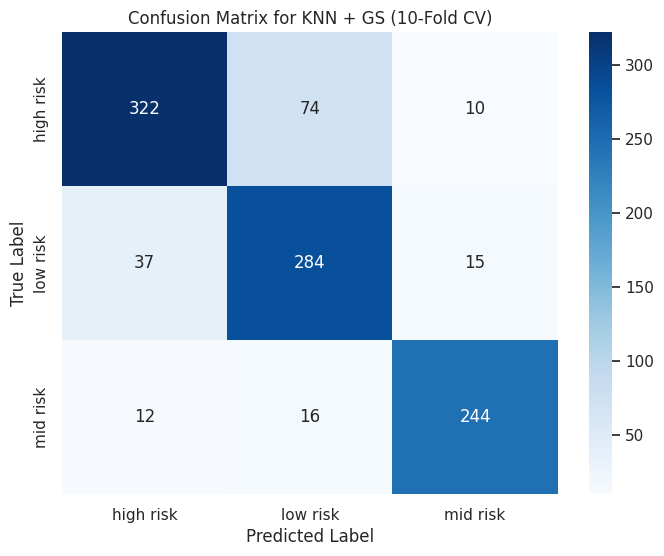

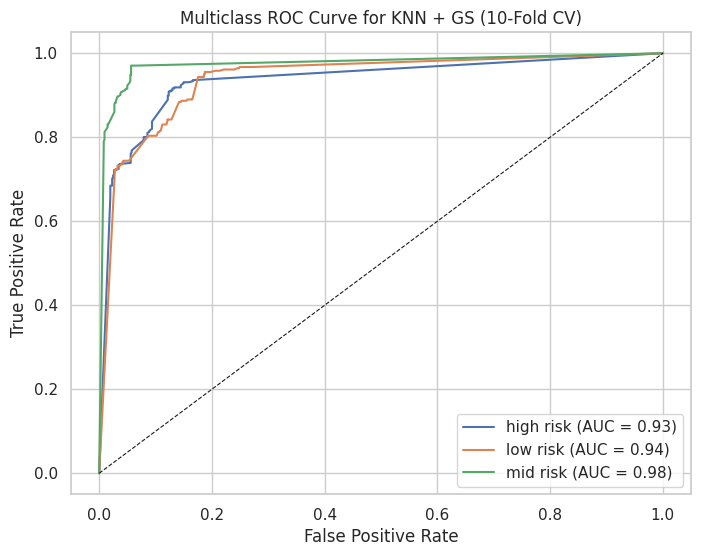


--- Evaluating Model: DecisionTree ---
Average Accuracy: 0.8540 (± 0.0317)
Average Macro Precision: 0.8641 (± 0.0244)
Average Macro Recall: 0.8610 (± 0.0288)
Average Macro F1-Score: 0.8585 (± 0.0286)
Average ROC AUC (OvR): 0.9422 (± 0.0195)


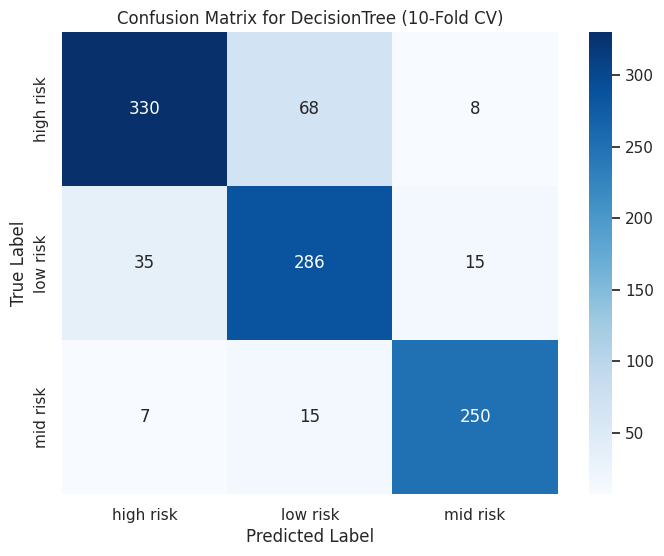

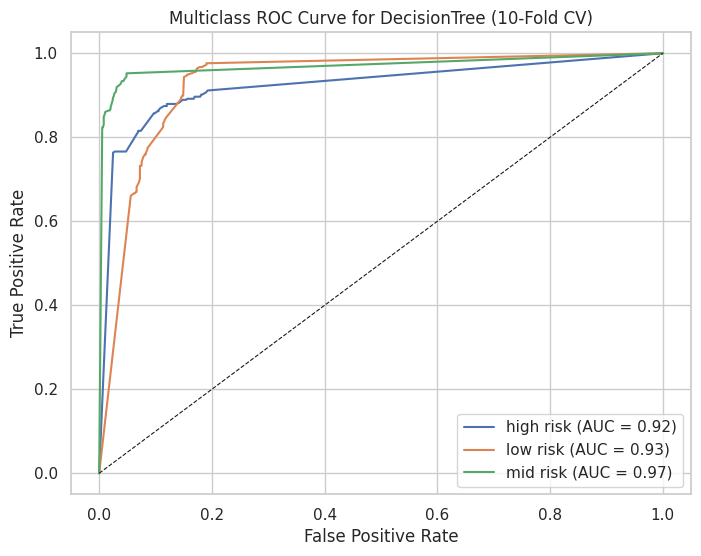


--- Evaluating Model: DecisionTree + GS ---
Average Accuracy: 0.8540 (± 0.0277)
Average Macro Precision: 0.8640 (± 0.0230)
Average Macro Recall: 0.8602 (± 0.0253)
Average Macro F1-Score: 0.8582 (± 0.0249)
Average ROC AUC (OvR): 0.9437 (± 0.0161)


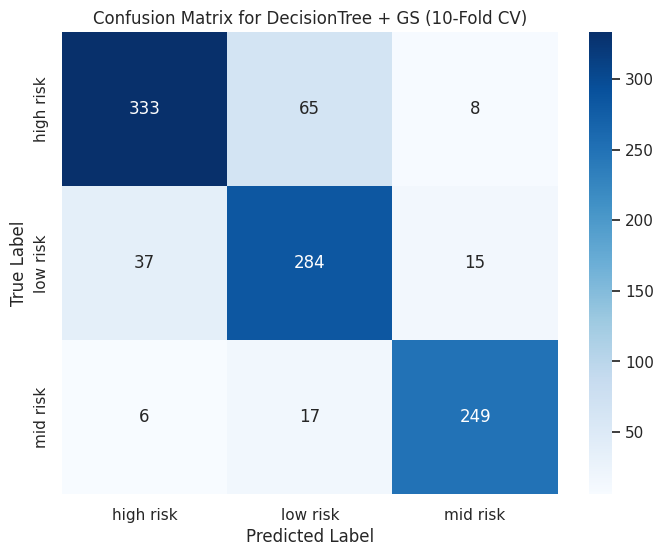

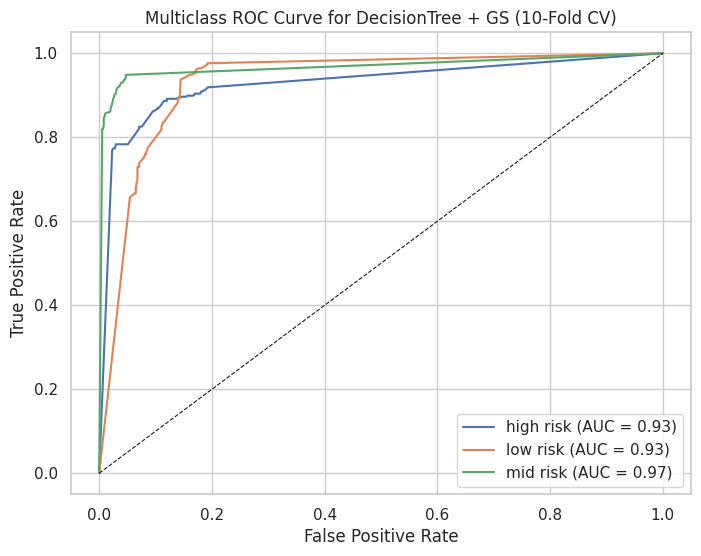


--- Evaluating Model: RandomForest ---
Average Accuracy: 0.8619 (± 0.0277)
Average Macro Precision: 0.8691 (± 0.0232)
Average Macro Recall: 0.8678 (± 0.0268)
Average Macro F1-Score: 0.8655 (± 0.0260)
Average ROC AUC (OvR): 0.9635 (± 0.0168)


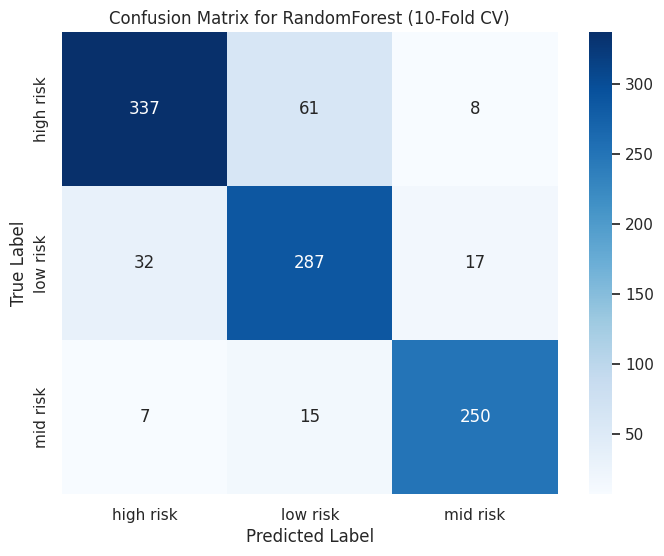

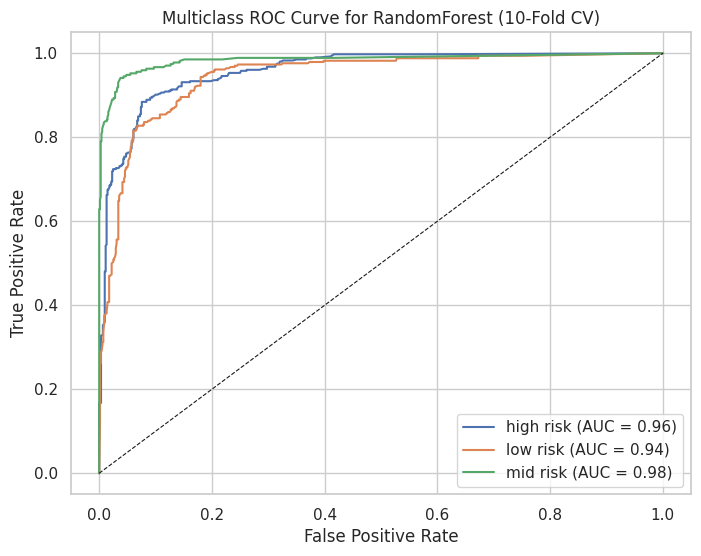


--- Evaluating Model: RandomForest + GS ---
Average Accuracy: 0.8550 (± 0.0291)
Average Macro Precision: 0.8630 (± 0.0259)
Average Macro Recall: 0.8615 (± 0.0276)
Average Macro F1-Score: 0.8590 (± 0.0275)
Average ROC AUC (OvR): 0.9637 (± 0.0163)


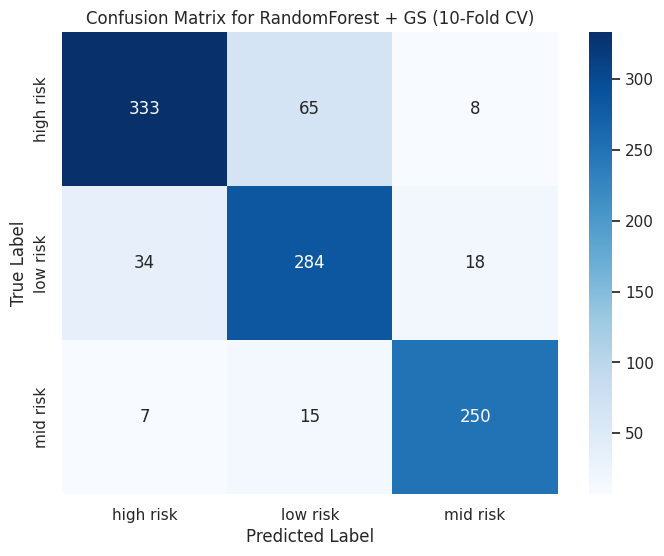

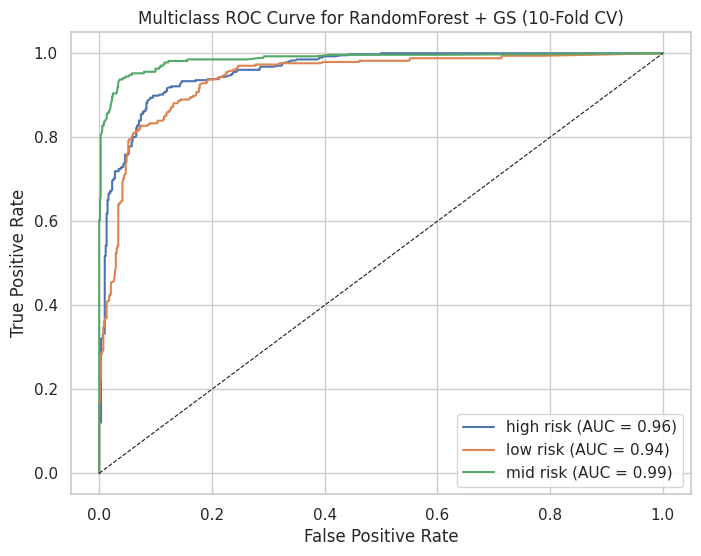


--- Evaluating Model: Bagging ---
Average Accuracy: 0.8520 (± 0.0312)
Average Macro Precision: 0.8636 (± 0.0232)
Average Macro Recall: 0.8592 (± 0.0286)
Average Macro F1-Score: 0.8565 (± 0.0295)
Average ROC AUC (OvR): 0.9543 (± 0.0192)


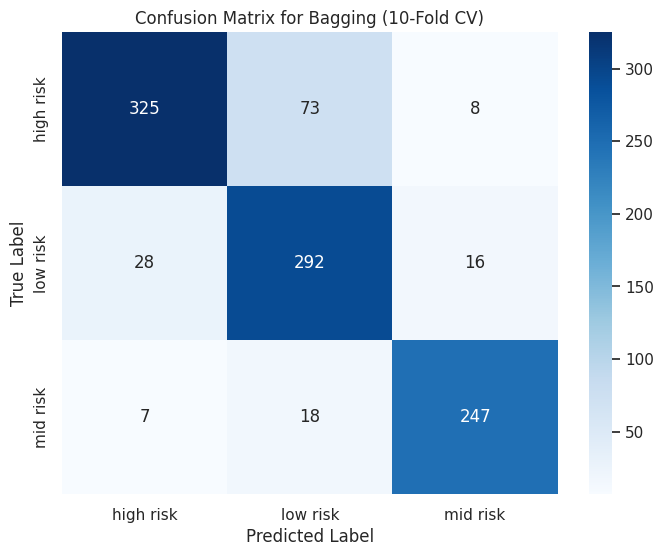

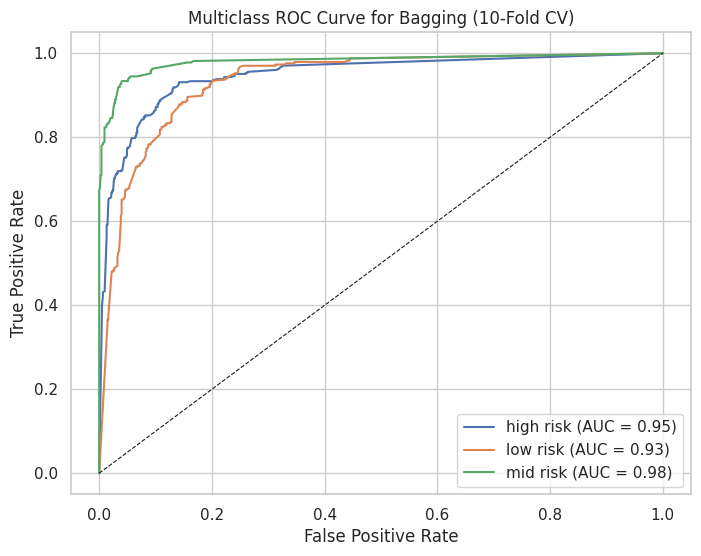


--- Evaluating Model: Bagging + GS ---
Average Accuracy: 0.8491 (± 0.0350)
Average Macro Precision: 0.8586 (± 0.0290)
Average Macro Recall: 0.8558 (± 0.0341)
Average Macro F1-Score: 0.8535 (± 0.0330)
Average ROC AUC (OvR): 0.9588 (± 0.0154)


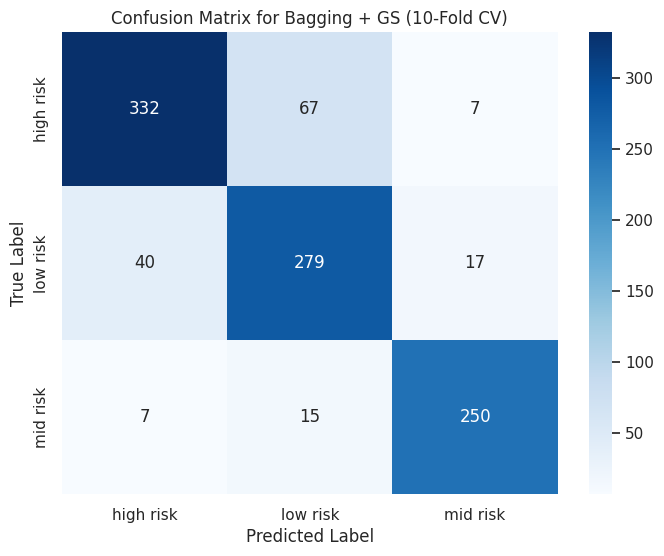

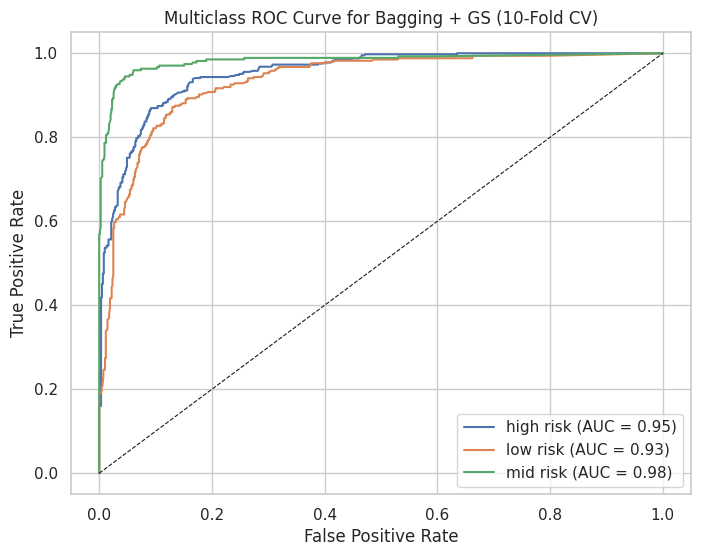


--- Evaluating Model: SVC ---
Average Accuracy: 0.8135 (± 0.0413)
Average Macro Precision: 0.8190 (± 0.0388)
Average Macro Recall: 0.8226 (± 0.0397)
Average Macro F1-Score: 0.8181 (± 0.0403)
Average ROC AUC (OvR): 0.9160 (± 0.0181)


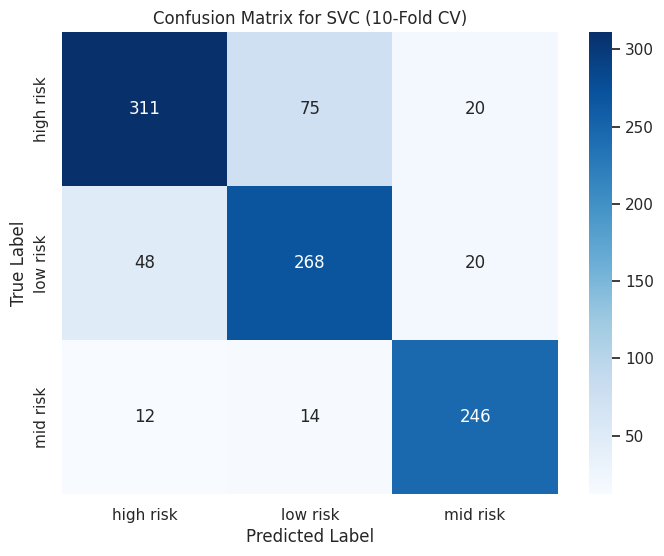

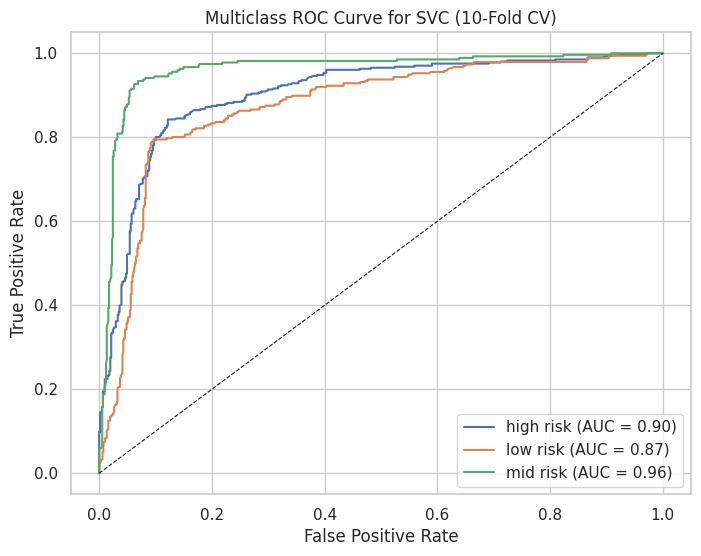


--- Evaluating Model: SVC + GS ---
Average Accuracy: 0.8322 (± 0.0343)
Average Macro Precision: 0.8384 (± 0.0303)
Average Macro Recall: 0.8394 (± 0.0362)
Average Macro F1-Score: 0.8361 (± 0.0333)
Average ROC AUC (OvR): 0.9235 (± 0.0168)


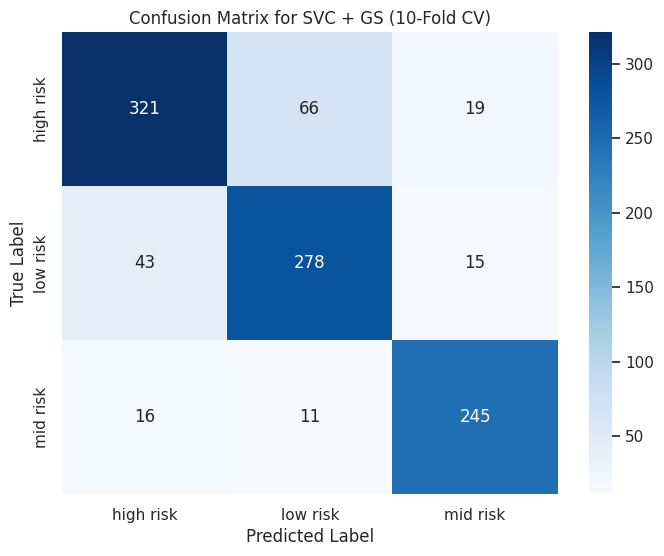

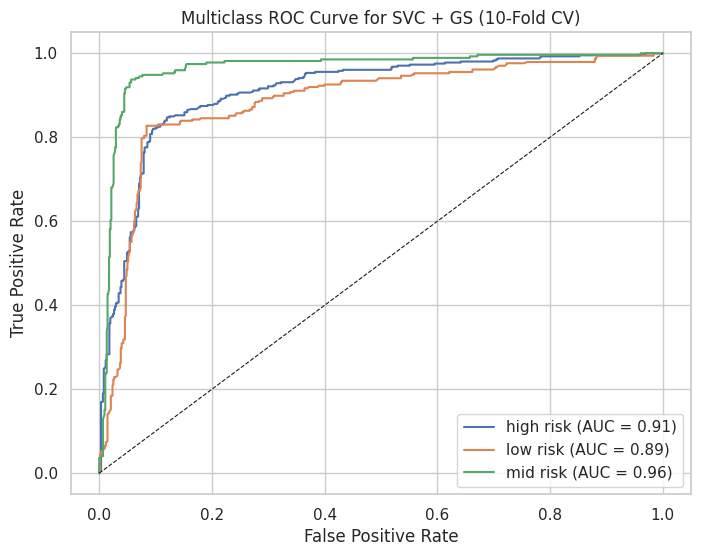


--- Finished Block 2: 10-Fold Cross-Validation Evaluation ---



In [ ]:
print("--- Starting Block 2: 10-Fold CV with SMOTE on train fold only ---")

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    for use_grid in [False, True]:
        if use_grid and name not in param_grids:
            continue

        tag = " + GS" if use_grid else ""
        print(f"\n--- Evaluating Model: {name}{tag} ---")

        accuracies, precisions, recalls, f1s, aucs = [], [], [], [], []
        all_y_true, all_y_pred, all_y_proba = [], [], []

        for train_index, test_index in cv.split(X, y):
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

            smote = SMOTE(random_state=42)
            X_train_res, y_train_res = smote.fit_resample(X_train_fold, y_train_fold)

            if use_grid:
                gs = GridSearchCV(model, param_grids[name], cv=5, scoring='f1_macro', n_jobs=-1, verbose=0)
                gs.fit(X_train_res, y_train_res)
                best_model = gs.best_estimator_
            else:
                model.fit(X_train_res, y_train_res)
                best_model = model

            y_pred = best_model.predict(X_test_fold)
            y_proba = best_model.predict_proba(X_test_fold)

            acc = accuracy_score(y_test_fold, y_pred)
            prec, rec, f1, _ = precision_recall_fscore_support(y_test_fold, y_pred, average='macro', zero_division=0)
            auc_score = roc_auc_score(y_test_fold, y_proba, multi_class='ovr')

            accuracies.append(acc)
            precisions.append(prec)
            recalls.append(rec)
            f1s.append(f1)
            aucs.append(auc_score)

            all_y_true.extend(y_test_fold)
            all_y_pred.extend(y_pred)
            all_y_proba.extend(y_proba)

        all_y_true = np.array(all_y_true)
        all_y_pred = np.array(all_y_pred)
        all_y_proba = np.array(all_y_proba)

        print(f"Average Accuracy: {np.mean(accuracies):.4f} (± {np.std(accuracies):.4f})")
        print(f"Average Macro Precision: {np.mean(precisions):.4f} (± {np.std(precisions):.4f})")
        print(f"Average Macro Recall: {np.mean(recalls):.4f} (± {np.std(recalls):.4f})")
        print(f"Average Macro F1-Score: {np.mean(f1s):.4f} (± {np.std(f1s):.4f})")
        print(f"Average ROC AUC (OvR): {np.mean(aucs):.4f} (± {np.std(aucs):.4f})")

        results_list.append({
            "Model": f"{name}{tag}",
            "Evaluation Method": "10-Fold CV (SMOTE on Train Only)",
            "Accuracy": np.mean(accuracies),
            "Precision (Macro)": np.mean(precisions),
            "Recall (Macro)": np.mean(recalls),
            "F1-Score (Macro)": np.mean(f1s),
            "ROC AUC (OvR)": np.mean(aucs)
        })

        # Confusion Matrix
        cm = confusion_matrix(all_y_true, all_y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title(f'Confusion Matrix for {name}{tag} (10-Fold CV)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # ROC Curve
        y_bin = label_binarize(all_y_true, classes=range(n_classes))
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], all_y_proba[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--', linewidth=0.8)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Multiclass ROC Curve for {name}{tag} (10-Fold CV)')
        plt.legend()
        plt.grid(True)
        plt.show()

print("\n" + "="*80)
print("--- Finished Block 2: 10-Fold Cross-Validation Evaluation ---")
print("="*80 + "\n")


In [ ]:
print("--- Comprehensive Comparison Report ---")

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Pivot the table for better comparison
pivot_df = results_df.pivot(index='Model', columns='Evaluation Method')

# Style the DataFrame for better readability
styled_pivot = pivot_df.style.background_gradient(
    cmap='viridis', axis=None, low=0.5, high=1.0
).format("{:.4f}").set_caption("Model Performance Comparison")

print("Displaying summary of model performance metrics:")
display(styled_pivot)

--- Comprehensive Comparison Report ---
Displaying summary of model performance metrics:
